# OSMnx features demo

Get street networks anywhere in the world from OpenStreetMap data then analyze and visualize them.

More info:

  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [142]:
import networkx as nx
import numpy as np
import geopandas as gpd
import fiona
import osmnx as ox
import requests
import skmob
import pandas as pd
import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

warnings.filterwarnings(action='once')
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.0.1'

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


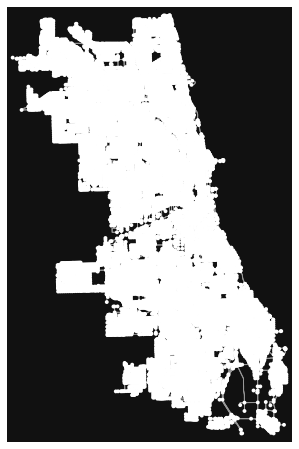

In [143]:
# get the walking network for piedmont
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G)

In [144]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


756338315.2232074

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

## Visualize street centrality

In [145]:
# assign speeds and traversal times to the edges
for u, v, k, d in G.edges(keys=True, data=True):
    if 'residential' in d['highway']:
        d['speed'] = 20
    elif 'tertiary' in d['highway']:
        d['speed'] = 30
    elif 'secondary' in d['highway']:
        d['speed'] = 40
    else:
        d['speed'] = 25
    
    # calculate time to traverse edge, in minutes
    d['time'] = d['length'] / (d['speed'] * 1609.34 / 60) #miles/hour to meters/minute

## Importing Crime Data (To be used later)....  for simulating an average crime scenario... Best case, Worst case and Average Crime Rate Data Statistic

In [146]:
data = pd.read_csv('Chicago_Data/all_data_0.5_0_timestamp.csv')#, sep = " ", names = ['time', 'lon', 'lat'])
data['user_id']=1

data['Timestamp']=pd.to_datetime(data['Timestamp']).dt.tz_localize(None)
if len(data['Timestamp'].dt.date.unique())==1:
    t0=(data['Timestamp'].dt.date.unique()[0]).strftime('%Y-%m-%d %H:%M:%S')
else:
    print("More Data than one day is passed in, only first day evaluated")
    t0=(data['Timestamp'].dt.date.unique()[0]).strftime('%Y-%m-%d %H:%M:%S')
data['Timestamp']=data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [147]:
Violent = data.groupby(['Priority']).get_group(1)
index = data.groupby(['Priority']).get_group(2)

frames = [Violent, index]
result = pd.concat(frames,sort='True')

Violent_grouped = result.sort_index(axis=0)
NonViolent_grouped = data.groupby(['Priority']).get_group(3)

In [148]:
VG = Violent_grouped.reset_index()
NVG = NonViolent_grouped.reset_index()

In [149]:
Violent_crime_data = VG[[ 'Timestamp','Latitude', 'Longitude','Priority','Service Time']]
NonViolent_crime_data = NVG[[ 'Timestamp','Latitude', 'Longitude','Priority','Service Time']]

In [150]:
crime_data = data[[ 'Timestamp','Latitude', 'Longitude','Priority','Service Time']] 
crime_data.head()

,Timestamp,Latitude,Longitude,Priority,Service Time
0,2014-05-07 00:00:00,41.898077,-87.729858,3,0 days 00:16:00
1,2014-05-07 00:00:00,41.854560,-87.708989,3,0 days 00:24:00
2,2014-05-07 00:00:00,41.981052,-87.839659,2,0 days 00:28:00
3,2014-05-07 00:00:00,41.885482,-87.627936,3,0 days 00:25:00
4,2014-05-07 00:01:00,41.797765,-87.714708,3,0 days 00:17:00


## Importing Police Location Data (Using that as location for police for basic simulation)

In [151]:
PS_data = pd.read_csv('Simulation_Data/Police_Stations_-_Map.csv')#, sep = " ", names = ['time', 'lon', 'lat'])
PS_data['user_id']=1

cr_lat=[]
cr_long=[]

for i in range(len(PS_data)):
    s = PS_data['LOCATION'][i]
    s= s[1:-1]
    f = [float(x) for x in s.split(", ")]
    cr_lat.append(f[0])
    cr_long.append(f[1])

PS_data['lat']=cr_lat
PS_data['long']=cr_long


/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [152]:
Gs = ox.utils_graph.get_largest_component(G, strongly=True)


In [153]:
PC_node=[]

for i in range(len(PS_data)):
    t = (ox.get_nearest_node(Gs, (cr_lat[i], cr_long[i])))
    PC_node.append(t)


In [154]:
class ndk:
    G=[]
    nodes=[]
    SPL={}
    def calc():
        for i in ndk.nodes:
            ndk.SPL[i]=nx.shortest_path_length(ndk.G, source=i, weight='time')
    def shortest_path_length(G, source, target, weight='none'):
        return ndk.SPL[source][target]
ndk.G=Gs
ndk.nodes=PC_node
ndk.calc()

In [155]:
def Cloning(li1): 
    li_copy = li1[:] 
    return li_copy

In [156]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [157]:
class Police:
    def __init__(self,ID,G,loc,resp,dt):
        self.ID=ID #a unique id
        self.G=G #pointer to the graph the officer travels on (Warning:edits to this graph have global consequences)
        self.loc=loc #the Node that the police officer is at
        self.resp=resp #true if the officer is responding to a crime event, false if patroling
        self.downtime=dt #Remaining time that the police is "down" due to a response event
        self.nodeInd=self.getNodeInd() #the index of the node that the officer is located in list(G.nodes())
    
    #tested
    #Randomly move the officer to an adjacent node if they are not responding
    def walk(self):
        if not(self.resp):
            wk= list(nx.classes.function.all_neighbors(self.G,(list(self.G.nodes)[self.nodeInd])))
            j = np.random.choice(wk)
            self.updateLoc(j)
            
    #moves the police officer toward the node they need to respond to
    def respond(self):
        if self.resp:
            return
    
    #updates the police location (no matter if they are responding or patroling)
    def update(self):
        i.walk()
        i.respond()
        
    #updates the location of the officer to the new Node (and changes the node ID)
    def updateLoc(self,newloc):
        self.loc=newloc
        self.nodeInd=self.getNodeInd()
        
    #gets the index of the node that corresponds to its ID
    def getNodeInd(self):
        return list(self.G.nodes).index(self.loc)

In [158]:
#initialize police officers as a list of variable from the class "Police"
NumberOfPolice=10
#Pol_loc=np.random.choice(len(G.nodes),size=(1,10),replace=False)
Police_officers=[]
for i in range(len(PC_node)):
    Pol_loc=PC_node[i]
    Police_officers.append(Police(i,G,Pol_loc,False,0))
#Question: how is the number of police officers taken into account here

## Evaluating Response time based on the nearest police location to the crime

## Initialize varibales : no of police associated with police location, no of police needed based on crime, 

In [159]:
crime_node=[]
Crime_geo =[]

for i in range(len(crime_data)):
    t = (ox.get_nearest_node(Gs, (crime_data['Latitude'][i], crime_data['Longitude'][i])))
    x = Point(crime_data['Longitude'][i],crime_data['Latitude'][i])
    Crime_geo.append(x)    
    crime_node.append(t)

In [160]:
VG_crime_node=[]
VG_Crime_geo=[]

for i in range(len(Violent_crime_data)):
    t = (ox.get_nearest_node(Gs, (Violent_crime_data['Latitude'][i], Violent_crime_data['Longitude'][i])))
    x = Point(Violent_crime_data['Longitude'][i],Violent_crime_data['Latitude'][i])
    VG_Crime_geo.append(x)
    VG_crime_node.append(t)

In [161]:
NVG_crime_node=[]
NVG_Crime_geo=[]

for i in range(len(NonViolent_crime_data)):
    t = (ox.get_nearest_node(Gs, (NonViolent_crime_data['Latitude'][i], NonViolent_crime_data['Longitude'][i])))
    x = Point(NonViolent_crime_data['Longitude'][i],NonViolent_crime_data['Latitude'][i])
    NVG_Crime_geo.append(x)
    NVG_crime_node.append(t)

In [162]:
data.head()

,Timestamp,Latitude,Longitude,#Responders,Police,Priority,Service Time,user_id
0,2014-05-07 00:00:00,41.898077,-87.729858,2,0,3,0 days 00:16:00,1
1,2014-05-07 00:00:00,41.854560,-87.708989,2,0,3,0 days 00:24:00,1
2,2014-05-07 00:00:00,41.981052,-87.839659,2,1,2,0 days 00:28:00,1
3,2014-05-07 00:00:00,41.885482,-87.627936,2,0,3,0 days 00:25:00,1
4,2014-05-07 00:01:00,41.797765,-87.714708,2,0,3,0 days 00:17:00,1


In [163]:
# This cell is to create time sequence in sec for crime data
# t0 is the time data for the day which is chosen from the crime data analysis.

from datetime import datetime
datetime_object=[]
VG_datetime_object=[]
NVG_datetime_object=[]
#t0 = '2014-08-01 00:00:00'  # worst case day
#t0 = '2014-10-28 00:00:00'  # median case day
#t0='2014-05-07 00:00:00'

print('Day Evaluating: ',t0)

t_ini = datetime.strptime(t0, '%Y-%m-%d %H:%M:%S')
time_seq=[]
VG_time_seq=[]
NVG_time_seq=[]

s0 ='00:00:00'
srvtime_object=[]
ser_time =[]
ss_ini = datetime.strptime(s0, '%H:%M:%S')

VG_srvtime_object=[]
VG_ser_time =[]

NVG_srvtime_object=[]
NVG_ser_time =[]

for i in range(len(crime_data)):
    datetime_str = crime_data['Timestamp'][i]
    datetime_object.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))
    tt = (datetime_object[i]-t_ini).total_seconds()
    time_seq.append(tt)
    
    srvtime_str = crime_data['Service Time'][i]
    srvtime_object.append(datetime.strptime(srvtime_str[7:-1],'%H:%M:%S'))
    ss = (srvtime_object[i]-ss_ini).total_seconds()
    ser_time.append(ss)
    
for i in range(len(Violent_crime_data)):
    datetime_str = Violent_crime_data['Timestamp'][i]
    VG_datetime_object.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))
    tt = (VG_datetime_object[i]-t_ini).total_seconds()
    VG_time_seq.append(tt)
    
    srvtime_str = Violent_crime_data['Service Time'][i]
    VG_srvtime_object.append(datetime.strptime(srvtime_str[7:-1],'%H:%M:%S'))
    ss = (VG_srvtime_object[i]-ss_ini).total_seconds()
    VG_ser_time.append(ss)


for i in range(len(NonViolent_crime_data)):
    datetime_str = NonViolent_crime_data['Timestamp'][i]
    NVG_datetime_object.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))
    tt = (NVG_datetime_object[i]-t_ini).total_seconds()
    NVG_time_seq.append(tt)
    
    srvtime_str = NonViolent_crime_data['Service Time'][i]
    NVG_srvtime_object.append(datetime.strptime(srvtime_str[7:-1],'%H:%M:%S'))
    ss = (NVG_srvtime_object[i]-ss_ini).total_seconds()
    NVG_ser_time.append(ss)


Day Evaluating:  2014-05-07 00:00:00


/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
time_min = [x / 60 for x in time_seq]
ser_min = [x / 60 for x in ser_time]
Crime = [time_min,crime_node,ser_min,Crime_geo]

In [165]:
VG_time_min = [x / 60 for x in VG_time_seq]
VG_ser_min = [x / 60 for x in VG_ser_time]
VG_Crime = [VG_time_min,VG_crime_node,VG_ser_min,VG_Crime_geo]


NVG_time_min = [x / 60 for x in NVG_time_seq]
NVG_ser_min = [x / 60 for x in NVG_ser_time]
NVG_Crime = [NVG_time_min,NVG_crime_node,NVG_ser_min,NVG_Crime_geo]

In [166]:
police = PC_node
NoOfPolice = 2;    #### Change no of police here


## Police Beats

In [167]:

multipol = fiona.open("Simulation_Data/Chicago_PB.shp")
multi= multipol.next()

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


In [168]:
fp = "Simulation_Data/Chicago_PB.shp"
polys  = gpd.read_file(fp)

In [195]:
print(polys)

   dist_label dist_num                                           geometry
0        17TH       17  POLYGON ((-87.71067 41.99737, -87.71067 41.997...
1        20TH       20  POLYGON ((-87.66029 41.99092, -87.66029 41.990...
2        31ST       16  POLYGON ((-87.82818 41.98384, -87.82816 41.983...
3        31ST       16  POLYGON ((-87.83365 41.97535, -87.83366 41.974...
4        19TH       19  POLYGON ((-87.64492 41.96973, -87.64431 41.969...
5        25TH       25  POLYGON ((-87.71740 41.93922, -87.71739 41.939...
6        14TH       14  POLYGON ((-87.69257 41.93943, -87.69253 41.939...
7        31ST       22  POLYGON ((-87.69123 41.69899, -87.69123 41.698...
8        22ND       22  POLYGON ((-87.63632 41.73618, -87.63592 41.736...
9         5TH        5  POLYGON ((-87.58776 41.72231, -87.58762 41.722...
10       24TH       24  POLYGON ((-87.67424 42.02300, -87.66541 42.022...
11       16TH       16  POLYGON ((-87.80655 42.01896, -87.80655 42.018...
12        8TH        8  POLYGON ((-87.

In [169]:
## This is to change the 31 police beat which is basically water to the surrounding police beat which is land

polys['dist_num'][2] = 16 #district 31
polys['dist_num'][3] = 16 #district 31
polys['dist_num'][7] = 22 #district 31

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
southern = polys[polys['dist_num']=='7']
poly = southern['geometry']

In [171]:
geometry =[Point (xy) for xy in zip(PS_data['long'],PS_data['lat'])]

In [172]:
geo_df = gpd.GeoDataFrame(PS_data,geometry = geometry)

<AxesSubplot:>

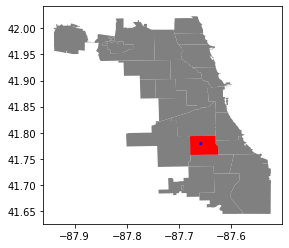

In [173]:
fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray');
southern.plot(ax=ax, facecolor='red');
geo_df[geo_df['DISTRICT'] == '7'].plot(ax=ax, color='blue', markersize=5)


In [174]:
import warnings
warnings.filterwarnings("ignore")

/Users/callieclark/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [175]:
### Police dispatch logic according to jurisdiction

def dipatch_logic(polys, pt):
    
    ## for loop to check that the point lies in which polygon 
    for x in range(len(polys)):
        if pt.within(polys['geometry'][x]):
            dis_t= polys['dist_num'][x]
            
            break
            
                        
    ## if the point is outside the polygons and the point is approximated to the closest polygon
    dis_t =0; ## variable to check if the point lied within the boundary       
    if dis_t==0:
        dd = 1000000;
        for x in range(len(polys)): 
            t1  = polys['geometry'][x]
            t = gpd.GeoSeries(t1)
            t.crs = 4326

            t2 = gpd.GeoSeries([pt])
            t2.crs = 4326

            dist = t.distance(t2)
            
            if (dist <= dd).bool():
                dd = dist
                dis_t = polys['dist_num'][x]              
            
    return dis_t   

In [176]:
# This is the main cell / function for calculation of response time. Input are the police station node data, crime
# data, no oif officer for a crime, shapefile for police beats and the street network

#police is nodes of police stations
def eva_resp_time(police,Crime,NoOfOfficer,polys,Gs):
    Resp_time = []
    orig_node = police

    my_array=[]
    arr_crime = [[0 for i in range(2)] for j in range(len(orig_node))]
    my_array = np.array(arr_crime).astype('int64')
    my_array[:,1]= orig_node 
    PC_stalk = [[0 for i in range(9)] for j in range(len(orig_node))]
    
    
    ## PC_stalk is the main list which is keeping track of all police station node. 
    # PC_stalk stores the assigned crime to a police station along with when was the crime assigned , its service time,the crimes being actively handles , crimes in waiting queue becuse of officers unavailability
       
            
    for x in range(len(orig_node)):
        PC_stalk[x][0] =orig_node[x]
    for x in range(len(orig_node)):
        for y in range(3,9):
            PC_stalk[x][y]=[]
    columnIndex = 0   
    for j in range(len(Crime[0])):
        dest_node = Crime[1][j]
        Crime_node = Crime[1][j]
        Crime_time = Crime[0][j] 
        Ser_time = Crime[2][j]
        if j !=len(Crime[0])-1:
            Crime_time_next = Crime[0][j+1]   
            
            
            
        ## Assign the crime node to police node ny calling the dispatch logic

        pt = Crime[3][j]
        x= dipatch_logic(polys, pt)
        
        ## if condition is added as sometimes the 'x' output was a string and sometimes it was a number
        # if condition is added to make the output x as a string data

        if not isinstance(x, str):
            x = str(x)
        te = PS_data[PS_data['DISTRICT'] == x]        
        trr = (ox.get_nearest_node(Gs, (te['lat'].values[0], te['long'].values[0])))        

        s = trr
        idx = np.argwhere(column(PC_stalk, 0) == s)[0][0]
        
        

        if PC_stalk[idx][1] < NoOfOfficer:  # if the officer are avaiable : assign crime as active
                PC_stalk[idx][1]= PC_stalk[idx][1]+1
                PC_stalk[idx][3].append(Crime_time)
                PC_stalk[idx][4].append(Crime_node)
                temp = ndk.shortest_path_length(Gs, PC_stalk[idx][0], Crime_node, weight='time')
                PC_stalk[idx][5].append(2*temp + Crime_time + Ser_time)
                Resp_time.append([temp,Crime_time])

        else : #-->  if officers are already occupied make a waiting queue for all the crimes being assinged

            PC_stalk[idx][2]= PC_stalk[idx][2]+1
            PC_stalk[idx][6].append(Crime_node)
            PC_stalk[idx][7].append(Crime_time)
            PC_stalk[idx][8].append(Ser_time)


        if j !=len(Crime[0])-1:
            ## Check if a PC node is going to available
            for idx in range(len(orig_node)):
                y=0
                while (PC_stalk[idx][1])>0 and y<=PC_stalk[idx][1]-1:
                    if PC_stalk[idx][5][y] <= Crime_time_next:
                        if PC_stalk[idx][2]>0:
                            PC_stalk[idx][2]= PC_stalk[idx][2]-1
                            temp1 = PC_stalk[idx][5][y]
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][3].append(temp1)
                            temp2 = PC_stalk[idx][6][0]     ##Change from y to 0
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][4].append(temp2)
                            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
                            wait = temp1 - PC_stalk[idx][7][0]
                            se_time = PC_stalk[idx][8][0]
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                            PC_stalk[idx][5].append(2*temp3 + temp1 + se_time)
                            Resp_time.append([wait+temp3,PC_stalk[idx][7][0]])
                            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
                            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
                            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
                        else:
                            PC_stalk[idx][1]= PC_stalk[idx][1]-1
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                    else:
                        y=y+1
    d=[]
    
    # The for loop below is for all the crime data whole response time index is 
    
    for idx in range(len(orig_node)):
        while PC_stalk[idx][2]>0:
            a = min(PC_stalk[idx][5])
            ind = PC_stalk[idx][5].index(a)
            PC_stalk[idx][2]= PC_stalk[idx][2]-1
            temp1 = PC_stalk[idx][5][ind]
            PC_stalk[idx][3].remove(PC_stalk[idx][3][ind])
            PC_stalk[idx][3].append(temp1)
            temp2 = PC_stalk[idx][6][0]
            PC_stalk[idx][4].remove(PC_stalk[idx][4][ind])
            PC_stalk[idx][4].append(temp2)
            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
            wait = temp1 - PC_stalk[idx][7][0]
            ser_time = PC_stalk[idx][8][0]
            PC_stalk[idx][5].remove(PC_stalk[idx][5][ind])
            PC_stalk[idx][5].append(2*temp3 + temp1 + ser_time)
            d.append([wait+temp3,PC_stalk[idx][7][0]])
            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
    Resp_time.extend(d)
    return Resp_time

## Voilent and Non Violent Response Time Evaluation

In [206]:
police_staffing=pd.read_csv('Simulation_Data/PoliceBeat_staffing.csv',index_col='assigned_district').drop(columns=['Unnamed: 0'])
police_staffing_dict=round(police_staffing['#Officers']/3).to_dict()

In [193]:
police = PC_node #PC_node is a list of all the crime lat/long values
Total_Responders = 40 #set by stats above
percent_police=0.75
NoOfPolice = Total_Responders*percent_police;    #### Change no of police here

ALtResp = Total_Responders-NoOfPolice;

In [177]:
# police = PC_node #PC_node is a list of all the crime lat/long values
# Total_Responders = 40 

# NoOfPolice = 10;    #### Change no of police here

# ALtResp = Total_Responders-NoOfPolice;

In [178]:
VG_resp_time = eva_resp_time(police,VG_Crime,NoOfPolice,polys,Gs)

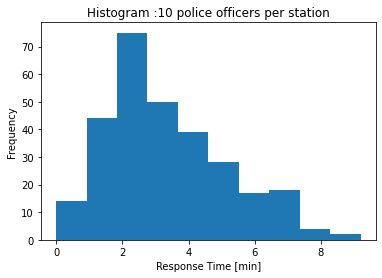

In [179]:
import matplotlib.pyplot as plt

VG_res_time  = column(VG_resp_time, 0)

plt.hist(VG_res_time)
plt.ylabel('Frequency')
plt.xlabel('Response Time [min]')
plt.title("Histogram :" + str(NoOfPolice) + " police officers per station");
 
plt.show()


In [180]:
import statistics


print('------------- Index Crime Statistics------------ ')
print('The median with ' + str(NoOfPolice) + ' officers per station is ', str(statistics.median(VG_res_time)) + ' [min]')
avg1 = sum(VG_res_time)/len(VG_res_time)
print('The average with ' + str(NoOfPolice) + ' officers per station is ', str(round(avg1,2))+' [min]')
print('The max response time with ' + str(2*NoOfPolice) + ' officers per station is ', str(max(VG_res_time)) +' [min]')


------------- Index Crime Statistics------------ 
The median with 10 officers per station is  2.9875398610610566 [min]
The average with 10 officers per station is  3.36 [min]
The max response time with 20 officers per station is  9.199005803621361 [min]


In [181]:
NVG_resp_time = eva_resp_time(police,NVG_Crime,ALtResp,polys,Gs)

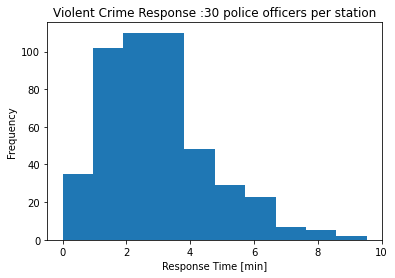

In [182]:
NVG_res_time = column(NVG_resp_time, 0)

plt.hist(NVG_res_time)
plt.ylabel('Frequency')
plt.xlabel('Response Time [min]')
plt.title("Violent Crime Response :" + str(ALtResp) + " police officers per station");

plt.show()

In [183]:
import statistics


print('------------- Non-Index Crime Statistics------------ ')
print('The median with ' + str(ALtResp) + ' officers per station is ', str(statistics.median(NVG_res_time)) + ' [min]')
avg1 = sum(NVG_res_time)/len(NVG_res_time)
print('The average with ' + str(ALtResp) + ' officers per station is ', str(round(avg1,2))+' [min]')
print('The max response time with ' + str(ALtResp) + ' officers per station is ', str(max(NVG_res_time)) +' [min]')


------------- Non-Index Crime Statistics------------ 
The median with 30 officers per station is  2.7989921334211547 [min]
The average with 30 officers per station is  2.98 [min]
The max response time with 30 officers per station is  9.53565623174717 [min]
